<a href="https://polly.elucidata.io/manage/workspaces?action=open_polly_notebook&amp;source=github&amp;path=ElucidataInc%2Fpolly-python%2Fblob%2Fmain%2FAnalyse%2Fconsumption_starter_notebooks%2FPharmacodb.ipynb&amp;kernel=elucidata%2FPython+3.10&amp;machine=gp" target="_parent"><img alt="Open in Polly" src="https://elucidatainc.github.io/PublicAssets/open_polly.svg"/></a>


# Welcome to Pollyglot Notebook.

In [ ]:
# installing packages
!sudo pip3 install polly-python --quiet 
!sudo pip3 install seaborn sklearn plotly --quiet
!sudo pip3 install joblib --quiet# to install joblib
!sudo pip3 install cmapPy --quiet
!sudo pip3 install plotly scanpy --quiet

In [ ]:
# importing packages

from joblib import Parallel, delayed
import os
import pandas as pd
from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress import GCToo
from cmapPy.pandasGEXpress import write_gct
from cmapPy.pandasGEXpress.concat import assemble_common_meta
from cmapPy.pandasGEXpress.concat import assemble_data
from polly.omixatlas import OmixAtlas
from polly.workspaces import Workspaces
import urllib.parse as urlparse
from urllib.parse import parse_qs
from json import dumps
import numpy as np
import plotly.express as px
import seaborn as sns
import plotly.figure_factory as ff
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Extracting one dataset of GDSC1000 for visualising DataMatrix

In [ ]:
# sample level information
url = 'https://compute.polly.elucidata.io/jupyter/user/1648786944051895-63321ea8a7ef4e46ae4bb683163092f7-549c2e96-b173-11ec-b1aa-caac265a8cfc/notebooks/polly_python_read_gct(copy)(16).ipynb?repo_id=1622113130397&repo_name=pcd&dataset_id=(5Z)-7-Oxozeaenol_pancreas_GDSC1000_drug_response&polly-func=open_notebook&polly-notebook-id=63321ea8a7ef4e46ae4bb683163092f7&initiator=omixatlas&project_id=8025&project_name=YL-trial&polly_app_wf_type=null'
parsed = urlparse.urlparse(url)
repo_vars_list = [parse_qs(parsed.query).get(query_url)[0] for query_url in ['repo_id', 'repo_name', 'dataset_id']]
repo_id=repo_vars_list[0]
repo_name=repo_vars_list[1]
dataset_id=repo_vars_list[2]
file_name = dataset_id+'.h5ad'

AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
omixatlas = OmixAtlas(AUTH_TOKEN)

query=f"SELECT * FROM {repo_name}.datasets WHERE dataset_id = '{dataset_id}'"
results=omixatlas.query_metadata(query)

results

In [ ]:
data = omixatlas.download_data(repo_id, dataset_id)
url = data.get('data').get('attributes').get('download_url')
status = os.system(f"wget -O '{file_name}' '{url}'")
if status == 0:
    print("Downloaded data successfully")
else:
    raise Exception("Download not successful")

In [ ]:
import pandas as pd
import cmapPy
from cmapPy.pandasGEXpress.parse_gct import parse

gct_obj = parse(file_name) ## Parse the file to create a gct object
df = gct_obj.data_df ## Extract the dataframe from the gct object
col_metadata = gct_obj.col_metadata_df # Extract the column metadata from the gct object
row_metadata = gct_obj.row_metadata_df # Extract the row metadata from the gct object
df

In [ ]:
col_metadata

In [ ]:
row_metadata

In [ ]:
import math
conc_data = row_metadata.applymap(math.log10)
conc_data

In [ ]:
!sudo pip3 install lmfit --quiet 

# In context of disease and tissue, plot the drug response graph for all the cell lines

In [ ]:
df = df.rename(columns=dict(zip(col_metadata.index,col_metadata["cell_name"]))) # cahnging names of columns as per user selection
df1 = df.copy()
df1["conc"] = pd.DataFrame(conc_data.iloc[:,0])
df1.plot(x="conc", y=list(df.columns),kind="line", figsize=(20, 20))


In [ ]:
polyline = np.linspace(1, 15, 50)
plt.plot(df1.iloc[:,-1],df1.iloc[:,0])
plt.scatter(df1.iloc[:,-1],df1.iloc[:,0])
plt.scatter(col_metadata.loc["(5Z)-7-Oxozeaenol_KP-2_GDSC1000_response","IC50"],50)
plt.title('(5Z)-7-Oxozeaenol_KP-2_GDSC1000') 
plt.xlabel("Drug Conc (log10 microM)")
plt.ylabel("Cell viability(%)")

In [ ]:
col_metadata.loc["(5Z)-7-Oxozeaenol_KP-2_GDSC1000_response","IC50"]

In [ ]:
df2 = col_metadata[["HS","Einf","EC50","AAC","IC50","DSS1","DSS2","DSS3","cell_name"]]
df2 = df2.set_index('cell_name')
df2.quantile([.25, .5, .75], axis = 0)

In [ ]:
df2.boxplot()

# RUN IT

In [ ]:
AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
omixatlas = OmixAtlas(AUTH_TOKEN)

### Dowmload the data parallely

def download_dataset(repo, id):
    """
    Downloads a single dataset with given repo_id and dataset_id
    """
    repo_id = repo
    dataset_id = id
    file_name = f"{dataset_id}.gct"
    data = omixatlas.download_data(repo_id, dataset_id)
    url = data.get('data').get('attributes').get('download_url')
    status = os.system(f"wget -O '{file_name}' '{url}'")
    if status == 0:
        print("Downloaded data successfully")
    else:
        raise Exception("Download not successful")
        
### Read gcts parallely

def read_gcts(dataset_ids):
    gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]
    results_gct = Parallel(n_jobs=4)(delayed(parse)(gct_file) for gct_file in gct_files)
    return results_gct

# Extracting all the GDSC1000 Datasets From PharmacoDB

In [ ]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM pcd.datasets WHERE data_type = 'Drug Response' AND source = 'GDSC1000' """
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)("pcd", i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

In [ ]:
All_Metadata_col.to_csv('PharmacoDB_GDSC1000.csv')

In [ ]:
!polly files copy --workspace-id 8911 --source PharmacoDB_GDSC1000.csv --destination polly://PharmacoDB_GDSC1000.csv

# Extracting all the CTRPv2 Datasets From PharmacoDB

In [ ]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM pcd.datasets WHERE data_type = 'Drug Response' AND source = 'CTRPv2' """
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)("pcd", i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

In [ ]:
All_Metadata_col.to_csv('PharmacoDB_CTRPv2.csv')

In [ ]:
!polly files copy --workspace-id 8911 --source PharmacoDB_CTRPv2.csv --destination polly://PharmacoDB_CTRPv2.csv

# Extracting all the CCLE Datasets From PharmacoDB

In [ ]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM pcd.datasets WHERE data_type = 'Drug Response' AND source = 'CCLE' """
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)("pcd", i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

In [ ]:
All_Metadata_col.to_csv('PharmacoDB_CCLE.csv')

In [ ]:
!polly files copy --workspace-id 8911 --source PharmacoDB_CCLE.csv --destination polly://PharmacoDB_CCLE.csv

# Extracting all the gCSI Datasets From PharmacoDB

In [ ]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM pcd.datasets WHERE data_type = 'Drug Response' AND source = 'gCSI' """
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)("pcd", i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

In [28]:
All_Metadata_col.to_csv('PharmacoDB_gCSI.csv')

In [ ]:
!polly files copy --workspace-id 8911 --source PharmacoDB_gCSI.csv --destination polly://PharmacoDB_gCSI.csv

# Extracting all the ALL Datasets From PharmacoDB

In [ ]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM pcd.datasets WHERE data_type = 'Drug Response' """
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)("pcd", i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

In [32]:
All_Metadata_col["source"].unique()

array(['GDSC1000', 'CTRPv2', 'CCLE', 'GRAY', 'FIMM', 'UHNBreast', 'gCSI'],
      dtype=object)

In [33]:
All_Metadata_col.to_csv('PharmacoDB_alldata.csv')

In [34]:
!polly files copy --workspace-id 8911 --source PharmacoDB_alldata.csv --destination polly://PharmacoDB_alldata.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Refreshing session...
Session refreshed!
PharmacoDB_alldata.csv
polly://PharmacoDB_alldata.csv
Error: 'NoneType' object has no attribute 'get'


In [ ]:
!polly files copy --workspace-id 8911 --source polly://PharmacoDB_alldata.csv --destination PharmacoDB_alldata.csv

In [36]:
data = pd.read_csv("PharmacoDB_alldata.csv")
data.head()

,cid,AAC,DSS1,DSS2,DSS3,EC50,Einf,HS,IC50,cell_name,drug_name,experiment_id,kw_curated_cell_line,kw_curated_cell_type,kw_curated_disease,kw_curated_drug,kw_curated_genetic_mod_type,kw_curated_modified_gene,kw_curated_tissue,source,tissue_name
0,(5Z)-7-Oxozeaenol_22RV1_GDSC1000_response,0.099063,0.000000,0.000000,0.000000,1.562500,0.025,0.406250,1.617330,22RV1,(5Z)-7-Oxozeaenol,159758,22Rv1,none,Prostatic Neoplasms,5z-7-oxozeaenol,none,none,prostate gland,GDSC1000,prostate
1,(5Z)-7-Oxozeaenol_23132-87_GDSC1000_response,0.131264,0.097841,0.021246,0.006879,0.530166,0.000,0.875827,0.530166,23132-87,(5Z)-7-Oxozeaenol,204845,23132/87,none,Stomach Neoplasms,5z-7-oxozeaenol,none,none,stomach,GDSC1000,stomach
2,(5Z)-7-Oxozeaenol_42-MG-BA_GDSC1000_response,0.184227,0.146488,0.031809,0.012929,0.228140,0.000,0.804737,0.228140,42-MG-BA,(5Z)-7-Oxozeaenol,176388,42-MG-BA,none,Glioblastoma,5z-7-oxozeaenol,none,none,central nervous system,GDSC1000,central_nervous_system
3,(5Z)-7-Oxozeaenol_451Lu_GDSC1000_response,0.686878,0.652087,0.141599,0.141599,-4.552750,0.000,0.111777,-4.552750,451Lu,(5Z)-7-Oxozeaenol,178362,451Lu,none,Melanoma,5z-7-oxozeaenol,none,none,skin,GDSC1000,skin
4,(5Z)-7-Oxozeaenol_5637_GDSC1000_response,0.060415,0.052311,0.011359,0.001240,0.717281,0.000,3.926500,0.717281,5637,(5Z)-7-Oxozeaenol,203010,5637,none,Urinary Bladder Neoplasms,5z-7-oxozeaenol,none,none,urinary tract,GDSC1000,urinary_tract


In [37]:
df2 = data[["HS","Einf","EC50","AAC","IC50","DSS1","DSS2","DSS3","cell_name","drug_name"]]
#df2 = df2.set_index('cell_name')
#df2.quantile([.25, .5, .75], axis = 0)

<AxesSubplot:>

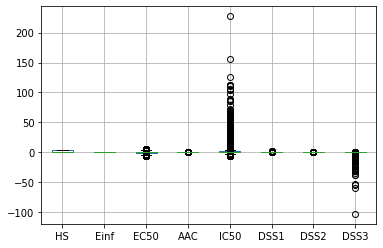

In [38]:
df2.boxplot()

In [39]:
df_new = data[data["cell_name"]== "A375"]
df_new = df_new[df_new["drug_name"] == "16-beta-bromoandrosterone"]
df_new

,cid,AAC,DSS1,DSS2,DSS3,EC50,Einf,HS,IC50,cell_name,drug_name,experiment_id,kw_curated_cell_line,kw_curated_cell_type,kw_curated_disease,kw_curated_drug,kw_curated_genetic_mod_type,kw_curated_modified_gene,kw_curated_tissue,source,tissue_name
972,16-beta-bromoandrosterone_A375_CTRPv2_rep_2_re...,0.013780,0.0,0.0,0.0,-0.21662,0.965049,4.0,NaN,A375,16-beta-bromoandrosterone,437053,A-375,none,"Melanoma, Amelanotic",16-beta-bromoandrosterone,none,none,skin,CTRPv2,skin
973,16-beta-bromoandrosterone_A375_CTRPv2_response,0.000232,0.0,0.0,0.0,1.91199,0.766006,4.0,NaN,A375,16-beta-bromoandrosterone,273336,A-375,none,"Melanoma, Amelanotic",16-beta-bromoandrosterone,none,none,skin,CTRPv2,skin


In [40]:
data[["HS","Einf","EC50","AAC","IC50","DSS1","DSS2","DSS3","cell_name","drug_name"]].isnull().sum()

HS                0
Einf              0
EC50              0
AAC               0
IC50         231503
DSS1              0
DSS2              0
DSS3              0
cell_name         0
drug_name         0
dtype: int64

In [41]:
len(data)

649870

In [42]:
duplicate = data[data.duplicated(["cell_name","drug_name"])]
duplicate

,cid,AAC,DSS1,DSS2,DSS3,EC50,Einf,HS,IC50,cell_name,drug_name,experiment_id,kw_curated_cell_line,kw_curated_cell_type,kw_curated_disease,kw_curated_drug,kw_curated_genetic_mod_type,kw_curated_modified_gene,kw_curated_tissue,source,tissue_name
973,16-beta-bromoandrosterone_A375_CTRPv2_response,0.000232,0.000000,0.000000,0.000000,1.911990,0.766006,4.000000,NaN,A375,16-beta-bromoandrosterone,273336,A-375,none,"Melanoma, Amelanotic",16-beta-bromoandrosterone,none,none,skin,CTRPv2,skin
977,16-beta-bromoandrosterone_A549_CTRPv2_rep_3_re...,0.008180,0.000000,0.000000,0.000000,3.494720,0.908716,0.266276,NaN,A549,16-beta-bromoandrosterone,419671,A-549,none,Adenocarcinoma of Lung,16-beta-bromoandrosterone,none,none,lung,CTRPv2,lung
978,16-beta-bromoandrosterone_A549_CTRPv2_response,0.027774,0.000000,0.000000,0.000000,3.118170,0.881447,0.140207,NaN,A549,16-beta-bromoandrosterone,273803,A-549,none,Adenocarcinoma of Lung,16-beta-bromoandrosterone,none,none,lung,CTRPv2,lung
990,16-beta-bromoandrosterone_AsPC-1_CTRPv2_response,0.026001,0.000000,0.000000,0.000000,1.035780,0.916573,0.218795,NaN,AsPC-1,16-beta-bromoandrosterone,529173,AsPC-1,none,"Carcinoma, Pancreatic Ductal",16-beta-bromoandrosterone,none,none,pancreas,CTRPv2,pancreas
1055,16-beta-bromoandrosterone_CAL-51_CTRPv2_response,0.001653,0.000000,0.000000,0.000000,0.211683,0.995373,0.354378,NaN,CAL-51,16-beta-bromoandrosterone,351182,CAL-51,none,Breast Neoplasms,16-beta-bromoandrosterone,none,none,breast,CTRPv2,breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649545,vorinostat:navitoclax (4:1 mol/mol)_NCI-H1869_...,0.088441,0.079658,0.017386,0.002471,1.111990,0.023079,4.000000,1.117120,NCI-H1869,vorinostat:navitoclax (4:1 mol/mol),467735,NCI-H1869,none,"Neoplasms, Squamous Cell",vorinostat:navitoclax (4:1 mol/mol),none,none,lung,CTRPv2,lung
649580,vorinostat:navitoclax (4:1 mol/mol)_NCI-H460_C...,0.046259,0.030928,0.006716,0.000881,1.425180,0.000000,1.910140,1.425180,NCI-H460,vorinostat:navitoclax (4:1 mol/mol),334159,NCI-H460,none,"Carcinoma, Large Cell",vorinostat:navitoclax (4:1 mol/mol),none,none,lung,CTRPv2,lung
649582,vorinostat:navitoclax (4:1 mol/mol)_NCI-H520_C...,0.175547,0.162652,0.037000,0.009809,0.540745,0.188770,3.871290,0.593929,NCI-H520,vorinostat:navitoclax (4:1 mol/mol),401771,NCI-H520,none,"Neoplasms, Squamous Cell",vorinostat:navitoclax (4:1 mol/mol),none,none,lung,CTRPv2,lung
649633,vorinostat:navitoclax (4:1 mol/mol)_P3HR-1_CTR...,0.189486,0.177306,0.040010,0.010944,0.500000,0.159375,4.000000,0.541673,P3HR-1,vorinostat:navitoclax (4:1 mol/mol),382506,P3HR-1,none,Burkitt Lymphoma,vorinostat:navitoclax (4:1 mol/mol),none,none,lymphoid tissue,CTRPv2,haematopoietic_and_lymphoid_tissue
